Loaded 5479 rows from 2010-01-01 00:00:00 to 2024-12-31 00:00:00
Time features created
Lag and rolling features created
Macroeconomic interaction features created
Price change indicators created
Holiday indicators created
Crisis indicators created
NaN counts before dropping:
LP_92_lag_1                  1
LP_92_lag_7                  7
LP_92_lag_30                30
LAD_lag_1                    1
LAD_lag_7                    7
LAD_lag_30                  30
LP_92_rolling_mean_7         6
LP_92_rolling_std_7          6
LP_92_rolling_mean_30       29
LP_92_rolling_std_30        29
LAD_rolling_mean_7           6
LAD_rolling_std_7            6
LAD_rolling_mean_30         29
LAD_rolling_std_30          29
Crude_Oil_lag_7              7
Crude_Oil_lag_30            30
Exchange_Rate_pct_change     1
LP_92_change                 1
LP_92_direction              1
LAD_change                   1
LAD_direction                1
dtype: int64

Shape after dropping NaN: (5449, 56)
Date range: 2010-01-31

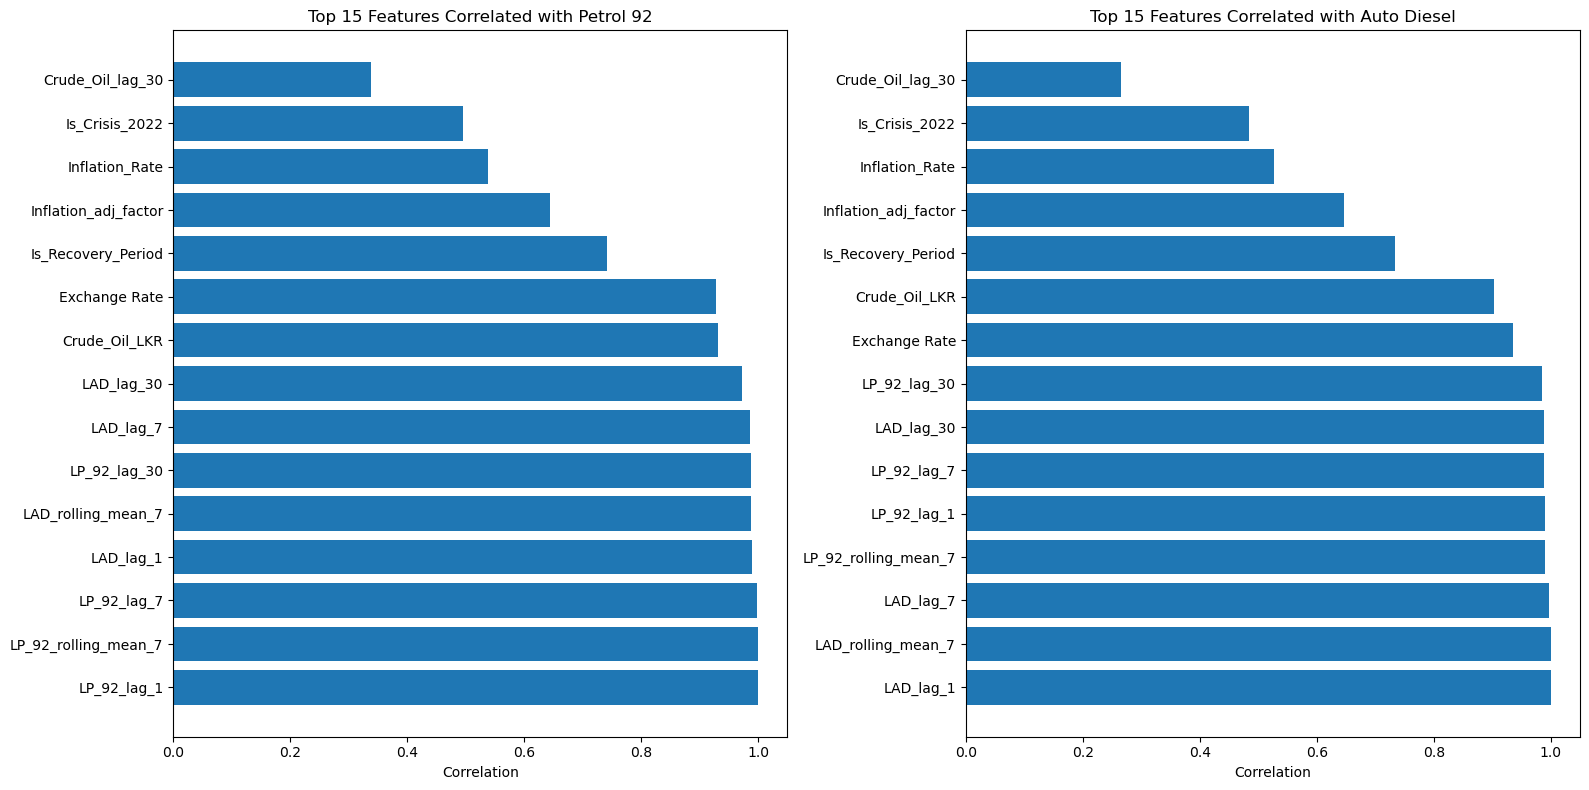

Highly correlated features (>0.95): ['Quarter', 'LP_92_lag_7', 'LP_92_lag_30', 'LAD_lag_1', 'LAD_lag_7', 'LAD_lag_30', 'LP_92_rolling_mean_7', 'LAD_rolling_mean_7', 'Crude_Oil_lag_7', 'Crude_Oil_lag_30', 'Inflation_adj_factor']

Consider removing some of these to reduce multicollinearity
Scaling 21 features
Features scaled using RobustScaler
Preprocessed data saved
Train: 4718 rows (2010-01-31 00:00:00 to 2022-12-31 00:00:00)
Validation: 273 rows (2023-01-01 00:00:00 to 2023-09-30 00:00:00)
Test: 458 rows (2023-10-01 00:00:00 to 2024-12-31 00:00:00)

Date ranges:
  Train: 2010-01-31 00:00:00 to 2022-12-31 00:00:00
  Val:   2023-01-01 00:00:00 to 2023-09-30 00:00:00
  Test:  2023-10-01 00:00:00 to 2024-12-31 00:00:00

Data splits saved
X_train shape: (4718, 31)
X_val shape: (273, 31)
X_test shape: (458, 31)


In [1]:
# %% [markdown]
# # Step 2: Feature Engineering for Fuel Price Prediction

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')

# Load merged data
df = pd.read_csv('../data/merged_fuel_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
print(f"Loaded {len(df)} rows from {df['Date'].min()} to {df['Date'].max()}")

# %% [markdown]
# ## Create Time-Based Features

# %%
# Extract date components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)

# Cyclical encoding for month (to capture seasonality)
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

print("Time features created")

# %% [markdown]
# ## Create Lag Features

# %%
# Define target columns
target_cols = ['LP_92', 'LAD']  # Petrol 92 and Auto Diesel

# Create lag features (1, 7, 30 days)
for target in target_cols:
    for lag in [1, 7, 30]:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)

# Create rolling statistics
for target in target_cols:
    for window in [7, 30]:
        df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window=window).mean()
        df[f'{target}_rolling_std_{window}'] = df[target].rolling(window=window).std()

print("Lag and rolling features created")

# %% [markdown]
# ## Create Macroeconomic Interaction Features

# %%
# Crude Oil * Exchange Rate (import cost in LKR)
df['Crude_Oil_LKR'] = df['Crude_Oil_USD'] * df['Exchange Rate']

# Lagged crude oil (since price changes take time to reflect)
df['Crude_Oil_lag_7'] = df['Crude_Oil_USD'].shift(7)
df['Crude_Oil_lag_30'] = df['Crude_Oil_USD'].shift(30)

# Exchange rate rate of change
df['Exchange_Rate_pct_change'] = df['Exchange Rate'].pct_change() * 100

# Inflation * Exchange Rate (purchasing power impact)
df['Inflation_adj_factor'] = df['Inflation_Rate'] / 100 * df['Exchange Rate']

print("Macroeconomic interaction features created")

# %% [markdown]
# ## Create Price Change Indicators

# %%
# Price change flags (for classification task)
for target in target_cols:
    # 1 if price increased, -1 if decreased, 0 if unchanged
    df[f'{target}_change'] = df[target].diff()
    df[f'{target}_direction'] = np.sign(df[f'{target}_change'])
    
    # Binary classification: 1 if price increased next day, else 0
    df[f'{target}_increase_next'] = (df[target].shift(-1) > df[target]).astype(int)

print("Price change indicators created")

# %% [markdown]
# ## Create Holiday/Event Indicators

# %%
# Sri Lankan public holidays (approximate - major ones)
def is_sinhala_tamil_new_year(date):
    """Approximate Sinhala/Tamil New Year (April 13-14)"""
    return (date.month == 4) and (date.day in [13, 14])

def is_vesak(date):
    """Approximate Vesak (full moon in May)"""
    return (date.month == 5) and (date.day >= 15 and date.day <= 25)  # Rough approximation

def is_christmas(date):
    return (date.month == 12) and (date.day == 25)

def is_new_year(date):
    return (date.month == 1) and (date.day == 1)

df['Is_Sinhala_Tamil_New_Year'] = df['Date'].apply(is_sinhala_tamil_new_year).astype(int)
df['Is_Vesak'] = df['Date'].apply(is_vesak).astype(int)
df['Is_Christmas'] = df['Date'].apply(is_christmas).astype(int)
df['Is_New_Year'] = df['Date'].apply(is_new_year).astype(int)

# Weekend indicator
df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)

print("Holiday indicators created")

# %% [markdown]
# ## Create Crisis Period Indicators

# %%
# COVID-19 pandemic period (2020-2021)
df['Is_COVID_Period'] = ((df['Date'] >= '2020-03-01') & (df['Date'] <= '2021-12-31')).astype(int)

# Sri Lankan economic crisis (2022)
df['Is_Crisis_2022'] = ((df['Date'] >= '2022-01-01') & (df['Date'] <= '2022-12-31')).astype(int)

# Post-crisis recovery (2023+)
df['Is_Recovery_Period'] = (df['Date'] >= '2023-01-01').astype(int)

print("Crisis indicators created")

# %% [markdown]
# ## Remove NaN rows (from lag features)

# %%
# Check NaN counts
nan_counts = df.isnull().sum()
print("NaN counts before dropping:")
print(nan_counts[nan_counts > 0])

# Drop rows with NaN (from lag features)
df_clean = df.dropna().reset_index(drop=True)
print(f"\nShape after dropping NaN: {df_clean.shape}")
print(f"Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")

# %% [markdown]
# ## Feature Selection and Correlation Analysis

# %%
# Select features for modeling
feature_cols = [
    # Time features
    'Month', 'Month_Sin', 'Month_Cos', 'Quarter', 'Is_Weekend',
    
    # Lag features
    'LP_92_lag_1', 'LP_92_lag_7', 'LP_92_lag_30',
    'LAD_lag_1', 'LAD_lag_7', 'LAD_lag_30',
    
    # Rolling features
    'LP_92_rolling_mean_7', 'LP_92_rolling_std_7',
    'LAD_rolling_mean_7', 'LAD_rolling_std_7',
    
    # Macroeconomic
    'Crude_Oil_USD', 'Crude_Oil_lag_7', 'Crude_Oil_lag_30',
    'Exchange Rate', 'Exchange_Rate_pct_change',
    'Crude_Oil_LKR',
    'GDP_Growth_Pct', 'Inflation_Rate',
    
    # Interaction
    'Inflation_adj_factor',
    
    # Event indicators
    'Is_Sinhala_Tamil_New_Year', 'Is_Vesak', 'Is_Christmas', 'Is_New_Year',
    'Is_COVID_Period', 'Is_Crisis_2022', 'Is_Recovery_Period'
]

# Target variables
target_cols = ['LP_92', 'LAD']

# Create feature matrix
X = df_clean[feature_cols]
y = df_clean[target_cols]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# %%
# Correlation with target
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Correlation with Petrol 92
corr_p92 = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [df_clean[f].corr(df_clean['LP_92']) for f in feature_cols]
}).sort_values('Correlation', ascending=False)

axes[0].barh(corr_p92['Feature'][:15], corr_p92['Correlation'][:15])
axes[0].set_xlabel('Correlation')
axes[0].set_title('Top 15 Features Correlated with Petrol 92')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Correlation with Auto Diesel
corr_ad = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [df_clean[f].corr(df_clean['LAD']) for f in feature_cols]
}).sort_values('Correlation', ascending=False)

axes[1].barh(corr_ad['Feature'][:15], corr_ad['Correlation'][:15])
axes[1].set_xlabel('Correlation')
axes[1].set_title('Top 15 Features Correlated with Auto Diesel')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('../feature_engineered_data/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

# %%
# Check for multicollinearity
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

print(f"Highly correlated features (>0.95): {high_corr}")
if high_corr:
    print("\nConsider removing some of these to reduce multicollinearity")

# %% [markdown]
# ## Feature Scaling

# %%
from sklearn.preprocessing import RobustScaler

# Identify numeric columns to scale (exclude binary/categorical)
binary_cols = ['Is_Weekend', 'Is_Sinhala_Tamil_New_Year', 'Is_Vesak', 
               'Is_Christmas', 'Is_New_Year', 'Is_COVID_Period', 
               'Is_Crisis_2022', 'Is_Recovery_Period']
cyclic_cols = ['Month_Sin', 'Month_Cos']

# Only include columns that exist in X
cols_to_scale = [col for col in feature_cols 
                 if col in X.columns and col not in binary_cols and col not in cyclic_cols]

print(f"Scaling {len(cols_to_scale)} features")

# Initialize scaler
scaler = RobustScaler()

# Fit and transform
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

print("Features scaled using RobustScaler")

# %%
# Save preprocessed data
X_scaled.to_csv('../feature_engineered_data/X_features.csv', index=False)
if y is not None:
    y.to_csv('../feature_engineered_data/y_targets.csv', index=False)

# Save scaler for later use
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

joblib.dump(scaler, '../models/feature_scaler.pkl')
joblib.dump(feature_cols, '../models/feature_columns.pkl')

print("Preprocessed data saved")

# %% [markdown]
# ## Time-Based Train/Validation/Test Split

# %%
# For time series, we must split chronologically
train_end = '2022-12-31'
val_end = '2023-09-30'

# Get the Date column from df_clean for indexing
dates = df_clean['Date']

# Create boolean masks
train_mask = dates <= train_end
val_mask = (dates > train_end) & (dates <= val_end)
test_mask = dates > val_end

# Apply masks to X_scaled and y
X_train = X_scaled[train_mask]
X_val = X_scaled[val_mask]
X_test = X_scaled[test_mask]

if y is not None:
    y_train = y[train_mask]
    y_val = y[val_mask]
    y_test = y[test_mask]
else:
    y_train = y_val = y_test = None

print(f"Train: {len(X_train)} rows ({dates[train_mask].min()} to {dates[train_mask].max()})")
print(f"Validation: {len(X_val)} rows ({dates[val_mask].min()} to {dates[val_mask].max()})")
print(f"Test: {len(X_test)} rows ({dates[test_mask].min()} to {dates[test_mask].max()})")

# Verify no data leakage
print(f"\nDate ranges:")
print(f"  Train: {dates[train_mask].min()} to {dates[train_mask].max()}")
print(f"  Val:   {dates[val_mask].min()} to {dates[val_mask].max()}")
print(f"  Test:  {dates[test_mask].min()} to {dates[test_mask].max()}")

# Check that splits are chronological and non-overlapping
assert dates[train_mask].max() < dates[val_mask].min(), "Train and validation overlap!"
assert dates[val_mask].max() < dates[test_mask].min(), "Validation and test overlap!"

# Save splits
X_train.to_csv('../feature_engineered_data/X_train.csv', index=False)
X_val.to_csv('../feature_engineered_data/X_val.csv', index=False)
X_test.to_csv('../feature_engineered_data/X_test.csv', index=False)

if y is not None:
    y_train.to_csv('../feature_engineered_data/y_train.csv', index=False)
    y_val.to_csv('../feature_engineered_data/y_val.csv', index=False)
    y_test.to_csv('../feature_engineered_data/y_test.csv', index=False)

print("\nData splits saved")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")